In [1]:
from keras.models import model_from_json
from keras.models import load_model
import numpy as np
import random
from tqdm import tqdm
from keras.utils import to_categorical
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
import cv2
def read_paths(dataset_path, list_path):
    imagepaths = []
    labelpaths = []
    for path in tqdm(open(list_path)):
        md5 = path.split('.')[0]
        imagepaths.append(dataset_path + "images/%s.jpg"%md5)
        labelpaths.append(dataset_path + "spline_labels/%s.json"%md5)
    return imagepaths, labelpaths

val_set_path = '/data/mc_data/MLDC/data/val/'
val_list_path = '/data/mc_data/MLDC/data/val/list.txt'
val_image_paths, val_label_paths = read_paths(val_set_path, val_list_path)

Using TensorFlow backend.
2015it [00:00, 262714.41it/s]


In [2]:
from keras.models import model_from_json
from keras.models import load_model
import numpy as np
import random
from tqdm import tqdm
from keras.utils import to_categorical
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
import cv2
# 从.json和.h5载入模型的结构和权重

def detect_points(img, model, shape):
    img = cv2.resize(img, (shape,shape))
    img = np.expand_dims(img,axis=0)
    points_logist = model.predict(img)
    points = np.argmax(points_logist, axis=-1)
    return points[0]
    
def detect_points_list(test_set_path, test_md5_paths, model, shape):
    points_list = np.zeros((len(test_md5_paths), shape, shape), np.uint8)
    i = 0
    for path in tqdm(test_md5_paths):
        md5 = path.split('.')[0]
        img = plt.imread(test_set_path + md5 +'.jpg')
        points_logist = detect_points(img, model, shape)
        points_list[i] = points
        i = i + 1
    return points_list

#model = model_from_json(open('segmodel_structure.json').read())
model = load_model('seg_two.h5')

val_labels = np.load("/home/mc16/pre_data/val_label_224.npy")
DATA_SHAPE  =224        
test_set_path = '/data/mc_data/MLDC/data/test1/images/' 
test_md5_paths = open('/home/mc16/test1_list.txt','r').readlines()


/home/mc16/.local/lib/python2.7/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


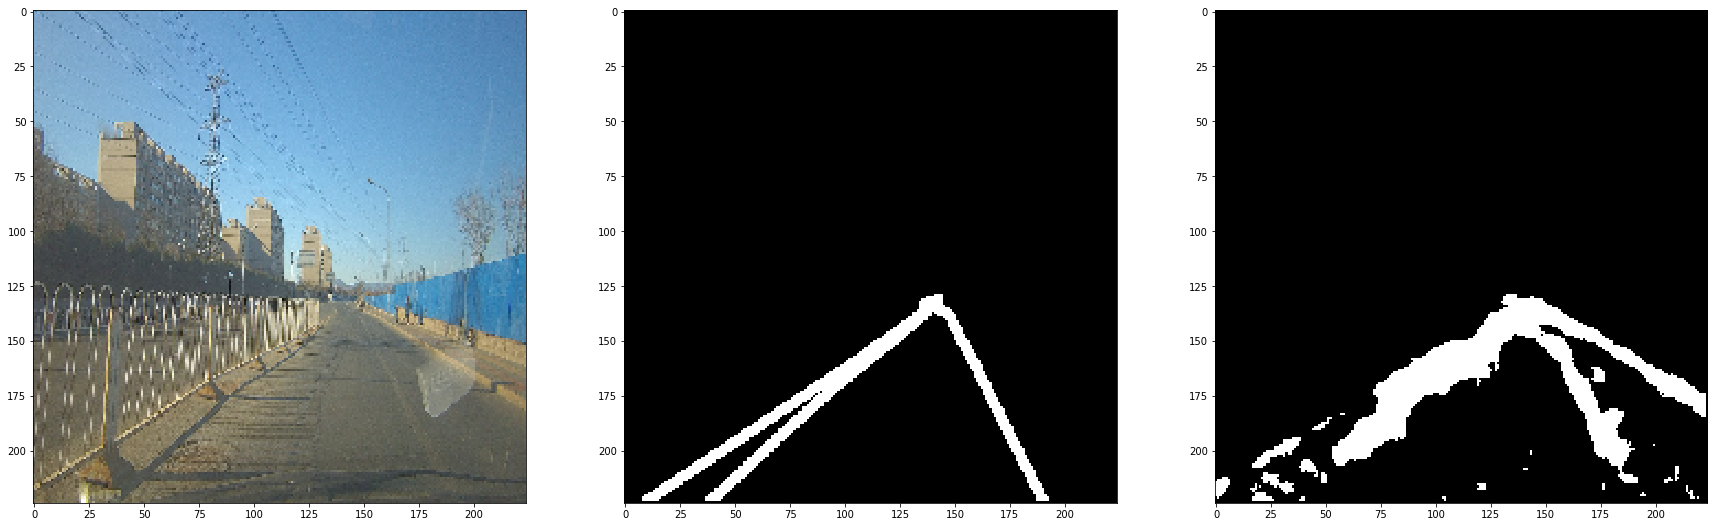

In [21]:

test_index = random.randint(0, len(val_labels))
test_label = val_labels[test_index,:,:,1]
test_img = plt.imread(val_image_paths[test_index])
test_img = cv2.resize(test_img,(DATA_SHAPE,DATA_SHAPE))
test_points = detect_points(test_img, model, DATA_SHAPE)
fig, axs = plt.subplots(1, 3, figsize=(30,30)) 
axs[0].imshow(test_img)
axs[1].imshow(test_label,cmap='gray')
axs[2].imshow(test_points,cmap='gray')
plt.show()

In [4]:
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import datetime
import random
import keras.backend as K
from keras.models import load_model
from keras.preprocessing import image
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import compute_unary, create_pairwise_bilateral, create_pairwise_gaussian, unary_from_softmax
import warnings
import os
def crf_image(img, model, gdims, bdims, iteras=1):
    img = cv2.resize(img, (DATA_SHAPE, DATA_SHAPE))
    score = model.predict(np.expand_dims(img,axis=0))

    softmax = score[0].transpose((2, 0, 1)) # [channel,shap,shape]
    unary = unary_from_softmax(softmax)
    unary = np.ascontiguousarray(unary)#(2,n)
    crf = dcrf.DenseCRF(img.shape[0] * img.shape[1], 2)
    crf.setUnaryEnergy(unary)

    feats = create_pairwise_gaussian(sdims=gdims, shape=img.shape[:2])
    crf.addPairwiseEnergy(feats, compat=3, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    feats = create_pairwise_bilateral(sdims=bdims, schan=(20, 20, 20), img=img, chdim=2)
    crf.addPairwiseEnergy(feats, compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    Q = crf.inference(iteras)
    
    res = np.argmax(Q, axis=0).reshape((img.shape[0], img.shape[1]))
    return res    

def cut_shit(mask, num, frac):
    cut_mask = np.array(mask)
    for j in range(224):
        for i in range(223-num):
            if np.sum(cut_mask[j, i:i+num]) > num*frac:
                cut_L = i + int(num * (1 - frac) / 2)
                cut_R = i + int(num * (1 + frac) / 2)
                cut_mask[j, cut_L:cut_R] = 0
    return cut_mask

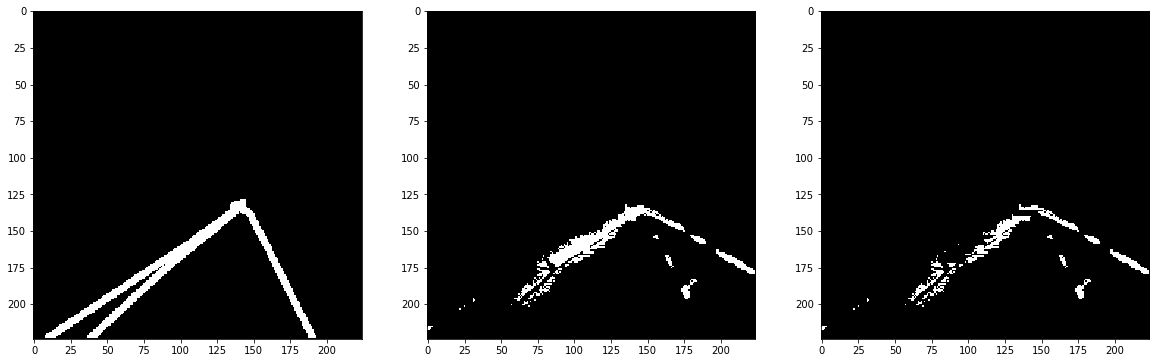

In [22]:
CRF_GDIMS = (2,2)
CRF_BDIMS = (50,50)
CRF_ITERAS = 1
CUT_WIDTH = 25
CUT_FRAC = 0.7

test_index = random.randint(0, len(val_labels))

test_crf = crf_image(test_img, model, gdims=CRF_GDIMS, bdims=CRF_BDIMS, iteras=CRF_ITERAS)
test_cut = cut_shit(test_crf, CUT_WIDTH, CUT_FRAC)
fig, axs = plt.subplots(1, 3, figsize=(20,20)) 
axs[0].imshow(test_label,cmap='gray')
axs[1].imshow(test_crf,cmap='gray')
axs[2].imshow(test_cut,cmap='gray')
plt.show()

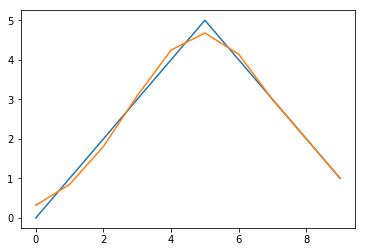

In [46]:
import numpy as np
import pylab as plt
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
#x = ar(range(10))
#y = ar([0,1,2,3,4,5,4,3,2,1])
def gaussian(x,*param):
    s1 = param[0]*np.exp(-np.power(x-param[2],2.)/(2*np.power(param[4],2.)))
    s2 = param[1]*np.exp(-np.power(x-param[3],2.)/(2*np.power(param[5],2.)))
    return s1+s2

popt,pcov = curve_fit(gaussian,x,y,p0=[3,4,3,6,1,1])

plt.plot(x,y)
plt.plot(x,gaussian(x,*popt))
plt.show()

In [36]:

def detect_test_list(model, shape):
    test_set_path = '/data/mc_data/MLDC/data/test1/images/' 
    test_md5_paths = open('/home/mc16/test1_list.txt','r').readlines()
    points_list = np.zeros((len(test_md5_paths), shape, shape), np.uint8)
    i = 0
    for path in tqdm(test_md5_paths):
        md5 = path.split('.')[0]
        img = plt.imread(test_set_path + md5 +'.jpg')
        points_logist = detect_points(img, model, shape)
        points_list[i] = points_logist
        i = i + 1
    return points_list

def detect_val_points(val_images, model, shape):
    points_list = np.zeros((len(val_images), shape, shape), np.uint8)
    i = 0
    for image in tqdm(val_images):
        points_list[i] = detect_points(image, model, shape)
        i = i + 1
    return points_list
DATA_SHAPE = 224
val_images = np.load('/home/mc16/pre_data/val_image_%s.npy'%DATA_SHAPE)
val_seg = detect_val_points(val_images, model, DATA_SHAPE)
# test1_seg = detect_test_list(model, DATA_SHAPE)

100%|██████████| 2015/2015 [00:18<00:00, 110.53it/s]


In [39]:
val_seg.shape

(2015, 224, 224)

In [40]:
CRF_GDIMS = (3,3)
CRF_BDIMS = (50,50)
CRF_ITERAS = 1
CUT_WIDTH = 30
CUT_FRAC = 0.5
def get_crf_list(image_list):
    crf_list = []
    for img in tqdm(image_list):
        crf = crf_image(img, model, gdims=CRF_GDIMS, bdims=CRF_BDIMS, iteras=CRF_ITERAS)
        cut = cut_shit(crf, CUT_WIDTH, CUT_FRAC)
        crf_list.append(cut)
    return crf_list

TIMEFORMAT = "%m-%d-%H:%M:%S"
#val_crf = get_crf_list(val_images)
val_crf = get_crf_list(val_images)
# time = datetime.datetime.now().strftime(TIMEFORMAT)
# np.save('/home/mc16/result/val_crf_%s.npy'%time, val_crf)

# test1_crf = get_crf_list(test1_images)
# time = datetime.datetime.now().strftime(TIMEFORMAT)
# np.save('/home/mc16/result/test1_crf_%s.npy'%time, test1_crf)

100%|██████████| 2015/2015 [11:26<00:00,  2.94it/s]


In [41]:
from sklearn.cluster import DBSCAN

def matrix_to_point(matrix):
    points = []
    for x in range(matrix.shape[0]):
        for y in range(matrix.shape[1]):
            if(matrix[x][y] == 1):
                points.append([x, y])
    return np.array(points, dtype=np.uint8)

def get_cluster_points(points, EPS = 1.5, MIN_SAMPLES = 3, minN=20):
    if len(points) == 0: 
        cluster_points = []
    else:
        arpoints = np.array(points, dtype=np.uint8)
        cluster_label = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit_predict(arpoints)
        max_label = np.max(cluster_label)
        cluster_points = []
        for label in range(-1, max_label+1):
            label_index = np.where(cluster_label == label)
            if(len(label_index[0]) > minN):
                cluster_points.append(arpoints[label_index])
    return np.array(cluster_points)

def cluster_to_img(cluster_points, shape):
    pic = np.zeros((shape, shape), np.uint8)
    num_label = cluster_points.shape[0]
    for i in range(num_label):
        for point in cluster_points[i]:
            pic[point[0], point[1]] = 50 + i * int((255 - 50) / num_label) 
    return pic

In [42]:
def get_cluster_list(crf_list):
    cluster_list = []
    for crf in tqdm(crf_list):
        point = matrix_to_point(crf)
        cluster = get_cluster_points(point, EPS = 1.5, MIN_SAMPLES = 3, minN=20)
        cluster_list.append(cluster)
    return cluster_list

val_cluster = get_cluster_list(val_crf)


100%|██████████| 2015/2015 [00:58<00:00, 34.63it/s]


In [43]:
import json
def np2json(arlines):
    json_lines = []
    for arline in arlines:
        json_line = []
        for point in arline:
            json_line.append({"x":int(point[1]), "y":int(point[0])})
        json_lines.append(json_line)
    return {"Lanes": json_lines}

def save_jsons(lines_list, list_path, json_path):
    test_md5_paths = open(list_path, 'r').readlines()
    for i, lines in tqdm(enumerate(lines_list)):
        md5 = test_md5_paths[i].split('.')[0]
        lines_json = np2json(lines)
        lines_str = json.dumps(lines_json)
        file = open(json_path + '%s.json'%md5,'w')
        file.write(lines_str)
        file.close()
        
val_list_path = '/data/mc_data/MLDC/data/val/list.txt'
val_json_path = '/home/mc16/result_json/val_results_clu/'
save_jsons(val_cluster, val_list_path, val_json_path)

2015it [00:03, 623.28it/s]
